In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt


In [2]:
df_SO2_perX = pd.read_csv('CSV_data\GEODAIR\O3\O3_moy_hor_per8.csv', sep = ';')

df_SO2_perX.describe()

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\axell\AppData\Local\Temp\ipykernel_168\1634635364.py:1: SyntaxWarning: invalid escape sequence '\G'
  df_SO2_perX = pd.read_csv('CSV_data\GEODAIR\O3\O3_moy_hor_per8.csv', sep = ';')


,valeur,valeur brute,taux de saisie,couverture temporelle,couverture de données,validité,Latitude,Longitude
count,54915.000000,54915.000000,54915.000000,54915.0,54915.000000,54915.000000,54915.000000,54915.000000
mean,77.591960,77.578829,98.523300,100.0,98.523300,0.965437,43.921851,2.385489
std,24.053999,24.054031,7.440464,0.0,7.440464,0.260637,12.356722,14.251810
min,0.100000,0.100000,4.000000,100.0,4.000000,-1.000000,-21.334406,-63.081481
25%,64.300000,64.275000,100.000000,100.0,100.000000,1.000000,44.060347,1.047892
50%,75.700000,75.725000,100.000000,100.0,100.000000,1.000000,46.652668,3.058333
75%,89.300000,89.275000,100.000000,100.0,100.000000,1.000000,48.729694,5.394716
max,206.300000,206.275000,100.000000,100.0,100.000000,1.000000,51.032761,55.582620


### On combine les dataframes dans leur longueure

Les data frames sont chacuns divisisés en 8 périodes en raison des limitations liées à la méthode d'importation des données. On concatène donc les données liées à chaque polluant dans la longueur en procédant de la dernière période à la première (chaque période représentant une période de 6 mois classé dans l'odre antichronologique au sein de chaque data frame).

In [3]:
folder_paths = [
   r"CSV_data\GEODAIR\NO2\NO2_moy_hor_per", #Utiliser soit r"..." soit des \\ sinon les "\N" de "\NO2" posent problème
    "CSV_data\GEODAIR\O3\O3_moy_hor_per",
    "CSV_data\GEODAIR\PM2.5\PM2.5_moy_jour_per",
    "CSV_data\GEODAIR\PM10\PM10_moy_jour_per",
    "CSV_data\GEODAIR\SO2\SO2_moy_hor_per"
    ]

#Ici l'instruction "range(8,1,-1)" permet de classer les chemins du plus récent au moins récent.
all_file_paths = [[ folder + str(i) + ".csv" for i in range(8,0,-1)] for folder in folder_paths]


all_combined_df = [pd.concat([pd.read_csv(file, sep = ";") for file in all_file_paths[i]]) for i in range(5)]

longeurs = [len(df) for df in all_combined_df]
longeurs
#Fonctionne
# Output : [523418, 437621, 306241, 528658, 129022] le df le plus long est celui des mesures de NO2

<>:3: SyntaxWarning: invalid escape sequence '\G'
<>:4: SyntaxWarning: invalid escape sequence '\G'
<>:5: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:3: SyntaxWarning: invalid escape sequence '\G'
<>:4: SyntaxWarning: invalid escape sequence '\G'
<>:5: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
C:\Users\axell\AppData\Local\Temp\ipykernel_168\2865527840.py:3: SyntaxWarning: invalid escape sequence '\G'
  "CSV_data\GEODAIR\O3\O3_moy_hor_per",
C:\Users\axell\AppData\Local\Temp\ipykernel_168\2865527840.py:4: SyntaxWarning: invalid escape sequence '\G'
  "CSV_data\GEODAIR\PM2.5\PM2.5_moy_jour_per",
C:\Users\axell\AppData\Local\Temp\ipykernel_168\2865527840.py:5: SyntaxWarning: invalid escape sequence '\G'
  "CSV_data\GEODAIR\PM10\PM10_moy_jour_per",
C:\Users\axell\AppData\Local\Temp\ipykernel_168\2865527840.py:6: SyntaxWarning: invalid escape sequence '\G'
  "CSV_data\GEODAIR\SO2\SO2_moy_

[523418, 437621, 306241, 528658, 129022]

### Jointures

Pour calculer les indices de polluants localement, le plus simple est de joindre les data frames sur la clé suivante : [date, localisation]. On commence par joindre les différents dataframes sur le plus petits d'entre eux afin de maximiser la complétude des champs de données.

In [4]:
all_combined_df[3].head(2)


,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Polluant,type d'influence,...,valeur,valeur brute,unité de mesure,taux de saisie,couverture temporelle,couverture de données,code qualité,validité,Latitude,Longitude
0,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01011,Metz-Centre,Urbaine,PM10,Fond,...,6.0,5.875000,µg-m3,100.0,100,100.0,A,1,49.119442,6.180833
1,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO GRAND EST,FR44ZAG02,ZAG METZ,FR01012,Metz-Borny,Urbaine,PM10,Fond,...,7.0,6.645833,µg-m3,100.0,100,100.0,A,1,49.110283,6.223336


In [5]:

# On précise les colonnes sur lesquels on applique la jonction
join_columns = ["Date de début", "Date de fin", "code site"]

# On sélectionne le data frame avec le plus petit nombre de lignes
smallest_df = min(all_combined_df, key=len)

# On initialise avec les plus petit data frame
result_df = smallest_df

# On joint chaque dataframe de notre liste "all_combined_df" avec un suffixe unique
for i, df in enumerate(all_combined_df):
    if df is not smallest_df:  # pour éviter l'auto-jonction
        result_df = pd.merge(
            result_df, 
            df, 
            on=join_columns, 
            how='inner', 
            suffixes=(None, f'_df{i}')  # Un suffixe unique pour chaque data frame
        )

# result_df contient maintenant le inner join of de tous les data frames sur les colonnes spécifées


In [6]:
columns_list = result_df.columns.tolist()

print(columns_list, len(columns_list))
# Output :
['Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Polluant', "type d'influence", 'Réglementaire', "type d'évaluation", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure', 'taux de saisie', 'couverture temporelle', 'couverture de données', 'code qualité', 'validité', 'Latitude', 'Longitude',
 'Organisme_df0', 'code zas_df0', 'Zas_df0', 'nom site_df0', "type d'implantation_df0", 'Polluant_df0', "type d'influence_df0", 'Réglementaire_df0', "type d'évaluation_df0", 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0', 'taux de saisie_df0', 'couverture temporelle_df0', 'couverture de données_df0', 'code qualité_df0', 'validité_df0', 'Latitude_df0', 'Longitude_df0',
 'Organisme_df1', 'code zas_df1', 'Zas_df1', 'nom site_df1', "type d'implantation_df1", 'Polluant_df1', "type d'influence_df1", 'Réglementaire_df1', "type d'évaluation_df1", 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1', 'taux de saisie_df1', 'couverture temporelle_df1', 'couverture de données_df1', 'code qualité_df1', 'validité_df1', 'Latitude_df1', 'Longitude_df1',
 'Organisme_df2', 'code zas_df2', 'Zas_df2', 'nom site_df2', "type d'implantation_df2", 'Polluant_df2', "type d'influence_df2", 'Réglementaire_df2', "type d'évaluation_df2", 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2', 'taux de saisie_df2', 'couverture temporelle_df2', 'couverture de données_df2', 'code qualité_df2', 'validité_df2', 'Latitude_df2', 'Longitude_df2',
 'Organisme_df3', 'code zas_df3', 'Zas_df3', 'nom site_df3', "type d'implantation_df3", 'Polluant_df3', "type d'influence_df3", 'Réglementaire_df3', "type d'évaluation_df3", 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3', 'taux de saisie_df3', 'couverture temporelle_df3', 'couverture de données_df3', 'code qualité_df3', 'validité_df3', 'Latitude_df3', 'Longitude_df3']
103
"""
On compte donc au total 103 colonnes, certaines sont peut-être redondantes, notamment les collones "lattitude" "longitude", "nom du site", "type d'implantation", et probablement les "code zas" ainsi que "zas"
Les valeurs les plus intéressantes sont donc les suivantes :

'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude',
'Polluant', "type d'influence", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure','code qualité', 'validité',
'Polluant_df0', 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0','code qualité_df0', 'validité_df0',
'Polluant_df1', 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1','code qualité_df1', 'validité_df1',
'Polluant_df2', 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2','code qualité_df2', 'validité_df2',
'Polluant_df3', 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3','code qualité_df3', 'validité_df3',"""

['Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Polluant', "type d'influence", 'Réglementaire', "type d'évaluation", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure', 'taux de saisie', 'couverture temporelle', 'couverture de données', 'code qualité', 'validité', 'Latitude', 'Longitude', 'Organisme_df0', 'code zas_df0', 'Zas_df0', 'nom site_df0', "type d'implantation_df0", 'Polluant_df0', "type d'influence_df0", 'Réglementaire_df0', "type d'évaluation_df0", 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0', 'taux de saisie_df0', 'couverture temporelle_df0', 'couverture de données_df0', 'code qualité_df0', 'validité_df0', 'Latitude_df0', 'Longitude_df0', 'Organisme_df1', 'code zas_df1', 'Zas_df1', 'nom site_df1', "type d'implantation_df1", 'Polluant_df1', "type d'influence_df1", 'Réglementaire_df1', "type d'évaluation_df1", 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'un

'\nOn compte donc au total 103 colonnes, certaines sont peut-être redondantes, notamment les collones "lattitude" "longitude", "nom du site", "type d\'implantation", et probablement les "code zas" ainsi que "zas"\nLes valeurs les plus intéressantes sont donc les suivantes :\n\n\'Date de début\', \'Date de fin\', \'Organisme\', \'code zas\', \'Zas\', \'code site\', \'nom site\', "type d\'implantation", \'Latitude\', \'Longitude\',\n\'Polluant\', "type d\'influence", \'type de valeur\', \'valeur\', \'valeur brute\', \'unité de mesure\',\'code qualité\', \'validité\',\n\'Polluant_df0\', \'type de valeur_df0\', \'valeur_df0\', \'valeur brute_df0\', \'unité de mesure_df0\',\'code qualité_df0\', \'validité_df0\',\n\'Polluant_df1\', \'type de valeur_df1\', \'valeur_df1\', \'valeur brute_df1\', \'unité de mesure_df1\',\'code qualité_df1\', \'validité_df1\',\n\'Polluant_df2\', \'type de valeur_df2\', \'valeur_df2\', \'valeur brute_df2\', \'unité de mesure_df2\',\'code qualité_df2\', \'validité_

#### Output : (classé par variable associées de chaque tableau)
<table>
    <tr> 
        <th> Premier df </th>
        <th> Deuxième df </th>
        <th> Troisième df </th>
        <th> Quatrième df </th>
        <th> Cinquième df </th>
    </tr>
    <tr>
        <td>'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Polluant', "type d'influence", 'Réglementaire', "type d'évaluation", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure', 'taux de saisie', 'couverture temporelle', 'couverture de données', 'code qualité', 'validité', 'Latitude', 'Longitude',</td>
        <td>'Organisme_df0', 'code zas_df0', 'Zas_df0', 'nom site_df0', "type d'implantation_df0", 'Polluant_df0', "type d'influence_df0", 'Réglementaire_df0', "type d'évaluation_df0", 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0', 'taux de saisie_df0', 'couverture temporelle_df0', 'couverture de données_df0', 'code qualité_df0', 'validité_df0', 'Latitude_df0', 'Longitude_df0',</td>
        <td>'Organisme_df1', 'code zas_df1', 'Zas_df1', 'nom site_df1', "type d'implantation_df1", 'Polluant_df1', "type d'influence_df1", 'Réglementaire_df1', "type d'évaluation_df1", 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1', 'taux de saisie_df1', 'couverture temporelle_df1', 'couverture de données_df1', 'code qualité_df1', 'validité_df1', 'Latitude_df1', 'Longitude_df1',</td>
        <td>'Organisme_df2', 'code zas_df2', 'Zas_df2', 'nom site_df2', "type d'implantation_df2", 'Polluant_df2', "type d'influence_df2", 'Réglementaire_df2', "type d'évaluation_df2", 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2', 'taux de saisie_df2', 'couverture temporelle_df2', 'couverture de données_df2', 'code qualité_df2', 'validité_df2', 'Latitude_df2', 'Longitude_df2',</td>
        <td>'Organisme_df3', 'code zas_df3', 'Zas_df3', 'nom site_df3', "type d'implantation_df3", 'Polluant_df3', "type d'influence_df3", 'Réglementaire_df3', "type d'évaluation_df3", 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3', 'taux de saisie_df3', 'couverture temporelle_df3', 'couverture de données_df3', 'code qualité_df3', 'validité_df3', 'Latitude_df3', 'Longitude_df3'</td>
    </tr>
</table>

On compte donc au total 103 colonnes, certaines sont peut-être redondantes, notamment les collones "lattitude" "longitude", "nom du site", "type d'implantation", et probablement les "code zas" ainsi que "zas"
Les valeurs les plus intéressantes sont donc les suivantes :
<table>
    <tr> 
        <th> Variables communes </th>
        <th> Premier df (S02)</th>
        <th> Deuxième df (NO2)</th>
        <th> Troisième df (O3)</th>
        <th> Quatrième df (PM2.5)</th>
        <th> Cinquième df (PM10)</th>
    </tr>
    <tr>
        <td>'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude',</td>
        <td>'Polluant', "type d'influence", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure','code qualité', 'validité',</td>
        <td>'Polluant_df0', 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0','code qualité_df0', 'validité_df0',</td>
        <td>'Polluant_df1', 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1','code qualité_df1', 'validité_df1',</td>
        <td>'Polluant_df2', 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2','code qualité_df2', 'validité_df2',</td>
        <td>'Polluant_df3', 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3','code qualité_df3', 'validité_df3',</td>
    </tr>
</table>

In [7]:
# On vérifie à quel polluant est associé chaque famille de colonnes
result_df[['Polluant','Polluant_df0','Polluant_df1','Polluant_df2','Polluant_df3']].head(1)

,Polluant,Polluant_df0,Polluant_df1,Polluant_df2,Polluant_df3
0,SO2,NO2,O3,PM2.5,PM10


In [8]:
# Soit la liste des variables les plus utiles, on peut l'utiliser pour extraire un version synthétique du de result_df
best_variables = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude',
    'Polluant', "type d'influence", 'type de valeur', 'valeur', 'valeur brute', 'unité de mesure','code qualité', 'validité',
    'Polluant_df0', 'type de valeur_df0', 'valeur_df0', 'valeur brute_df0', 'unité de mesure_df0','code qualité_df0', 'validité_df0',
    'Polluant_df1', 'type de valeur_df1', 'valeur_df1', 'valeur brute_df1', 'unité de mesure_df1','code qualité_df1', 'validité_df1',
    'Polluant_df2', 'type de valeur_df2', 'valeur_df2', 'valeur brute_df2', 'unité de mesure_df2','code qualité_df2', 'validité_df2',
    'Polluant_df3', 'type de valeur_df3', 'valeur_df3', 'valeur brute_df3', 'unité de mesure_df3','code qualité_df3', 'validité_df3',
]

best_df = result_df[best_variables]
best_df.sample(10)

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Latitude,Longitude,...,unité de mesure_df2,code qualité_df2,validité_df2,Polluant_df3,type de valeur_df3,valeur_df3,valeur brute_df3,unité de mesure_df3,code qualité_df3,validité_df3
20413,2020/06/16 00:00:00,2020/06/16 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,14.0,13.587500,µg-m3,A,1
4215,2023/04/13 00:00:00,2023/04/13 23:59:59,ATMO REUNION,FR04ZAR02,ZAR VOLCAN,FR38011,Station Luther King,Urbaine,-21.334406,55.459060,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.041667,µg-m3,A,1
4749,2023/05/17 00:00:00,2023/05/17 23:59:59,GWAD'AIR,FR01ZRE01,ZR GUADELOUPE,FR37010,BT_PICHON,Urbaine,15.994349,-61.727203,...,µg/m3,A,1,PM10,Moy. journalière,29.0,29.425000,µg/m3,A,1
12074,2021/10/02 00:00:00,2021/10/02 23:59:59,ATMO REUNION,FR04ZAR01,ZAR SAINT-DENIS,FR38008,Ecole JOINVILLE,Urbaine,-20.884575,55.453906,...,µg-m3,A,1,PM10,Moy. journalière,23.0,23.183333,µg-m3,A,1
9182,2022/03/19 00:00:00,2022/03/19 23:59:59,ATMO AUVERGNE-RHÔNE-ALPES,FR84ZAG02,ZAG GRENOBLE,FR15043,Grenoble Les Frenes,Urbaine,45.161900,5.735600,...,µg-m3,A,1,PM10,Moy. journalière,47.0,46.500000,µg-m3,A,1
12041,2021/09/30 00:00:00,2021/09/30 23:59:59,ATMO AUVERGNE-RHÔNE-ALPES,FR84ZAG02,ZAG GRENOBLE,FR15043,Grenoble Les Frenes,Urbaine,45.161900,5.735600,...,µg-m3,A,1,PM10,Moy. journalière,9.0,9.462500,µg-m3,A,1
2384,2023/12/05 00:00:00,2023/12/05 23:59:59,GWAD'AIR,FR01ZRE01,ZR GUADELOUPE,FR37010,BT_PICHON,Urbaine,15.994349,-61.727203,...,µg/m3,R,1,PM10,Moy. journalière,9.0,8.895833,µg/m3,R,1
305,2023/07/17 00:00:00,2023/07/17 23:59:59,QUALITAIR CORSE,FR94ZAR01,ZAR AJACCIO,FR41001,AJACCIO CANETTO,Urbaine,41.924694,8.735694,...,µg-m3,A,1,PM10,Moy. journalière,34.0,33.516667,µg-m3,A,1
9875,2022/05/05 00:00:00,2022/05/05 23:59:59,QUALITAIR CORSE,FR94ZAR01,ZAR AJACCIO,FR41001,AJACCIO CANETTO,Urbaine,41.924694,8.735694,...,µg-m3,A,1,PM10,Moy. journalière,21.0,21.012500,µg-m3,A,1
18521,2020/01/09 00:00:00,2020/01/09 23:59:59,ATMO REUNION,FR04ZAR01,ZAR SAINT-DENIS,FR38008,Ecole JOINVILLE,Urbaine,-20.884575,55.453906,...,µg-m3,A,1,PM10,Moy. journalière,19.0,18.891667,µg-m3,A,1


In [9]:
# On peut vérifier que l'on a aucune valeur manquante
missing_values = pd.DataFrame(best_df.isna().sum())
missing_values


,0
Date de début,0
Date de fin,0
Organisme,0
code zas,0
Zas,0
code site,0
nom site,0
type d'implantation,0
Latitude,0
Longitude,0


In [10]:
# On définit une fonction pour renommer les colonnes
# Définir les colonnes qui doivent garder leur nom tel quel
columns_to_keep = [
    'Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas', 
    'code site', 'nom site', "type d'implantation", 'Latitude', 'Longitude'
]

# Définir la fonction pour renommer les colonnes
def rename_columns(column_name):
    # Vérifier si la colonne doit conserver son nom
    if column_name in columns_to_keep:
        return column_name
    # Ajouter le suffixe "_SO2" pour les colonnes sans suffixe qui ne sont pas dans columns_to_keep
    elif not any(column_name.endswith(suffixe) for suffixe in ["_df0", "_df1", "_df2", "_df3"]):
        return f"{column_name}_SO2"
    # Remplacer les suffixes spécifiques
    elif column_name.endswith("_df0"):
        return column_name.replace("_df0", "_NO2")
    elif column_name.endswith("_df1"):
        return column_name.replace("_df1", "_O3")
    elif column_name.endswith("_df2"):
        return column_name.replace("_df2", "_PM2.5")
    elif column_name.endswith("_df3"):
        return column_name.replace("_df3", "_PM10")
    else:
        return column_name

best_df = best_df.rename(columns=rename_columns)
best_df.head(5)

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Latitude,Longitude,...,unité de mesure_PM2.5,code qualité_PM2.5,validité_PM2.5,Polluant_PM10,type de valeur_PM10,valeur_PM10,valeur brute_PM10,unité de mesure_PM10,code qualité_PM10,validité_PM10
0,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1
1,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1
2,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1
3,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,µg-m3,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1
4,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO NORMANDIE,FR28ZAR01,ZAR LE-HAVRE,FR05090,Le Havre ville-haute,Urbaine,49.514686,0.100645,...,µg-m3,A,1,PM10,Moy. journalière,20.0,20.391667,µg-m3,A,1


In [11]:
from indice_atmo import *

In [12]:
best_df['iqa'] = best_df[["valeur_SO2","valeur_O3","valeur_NO2","valeur_PM2.5","valeur_PM10"]].apply(iqa, axis = 1)
best_df['atmo'] = best_df[["valeur_SO2","valeur_O3","valeur_NO2","valeur_PM2.5","valeur_PM10"]].apply(atmo, axis = 1)
best_df[['iqa','atmo']].head(5)

c:\Users\axell\OneDrive\Documents\ENSAE\Projet-data-science-Mornand-Merienne\indice_atmo.py:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  valeurs_indice = [50*mesure_polluants_iqa[i]/valeurs_ref[i] for i in range(5)]
c:\Users\axell\OneDrive\Documents\ENSAE\Projet-data-science-Mornand-Merienne\indice_atmo.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if mesure_polluants[i] > tableau_ref[i][4] :
c:\Users\axell\OneDrive\Documents\ENSAE\Projet-data-science-Mornand-Merienne\indice_atmo.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

,iqa,atmo
0,111.714286,dégradé
1,111.714286,dégradé
2,111.714286,dégradé
3,111.714286,dégradé
4,142.714286,dégradé


<Axes: xlabel='atmo'>

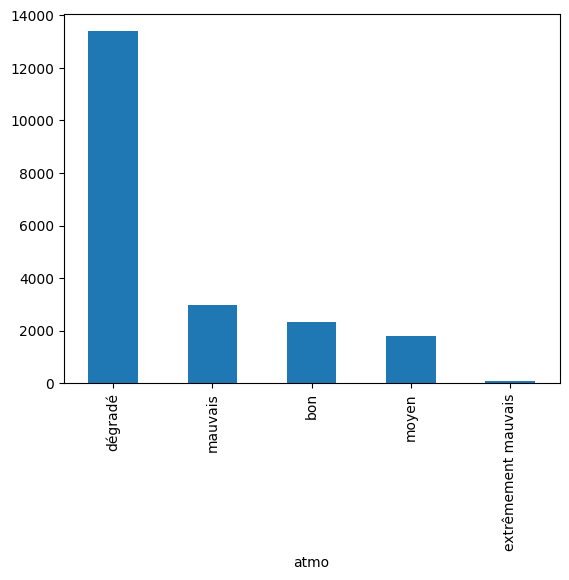

In [13]:
best_df["atmo"].value_counts().plot(kind = "bar")

<Axes: ylabel='Frequency'>

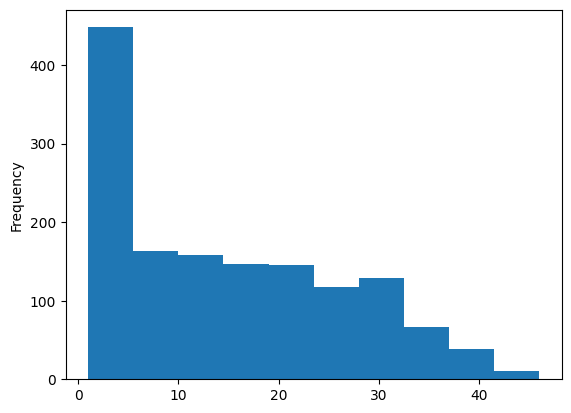

In [14]:
best_df["iqa"].value_counts().plot(kind = "hist", bins = 10)

In [15]:
pd.plotting.scatter_matrix(best_df, figsize=(20, 20), diagonal='hist')  # Diagonal can be 'hist' or 'kde'
plt.show()

KeyboardInterrupt: 

<Axes: xlabel='Longitude', ylabel='Latitude'>

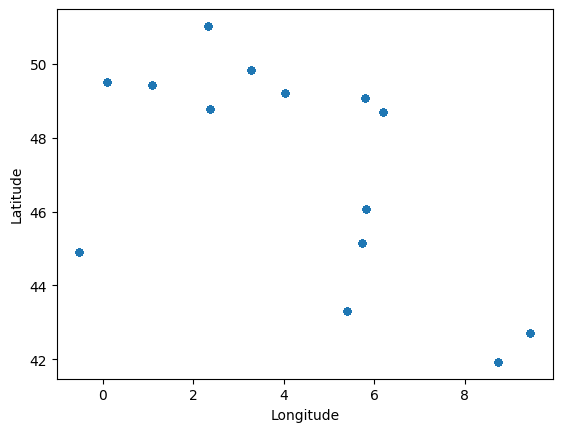

In [ ]:
best_df[(best_df['Longitude'].abs()<20)].plot(kind = 'scatter', x = 'Longitude', y = 'Latitude')

### Problème
On ne compte que 14 points de mesure en métropole

## API Geod'air

Clé d'API : XToid1ui5S5KioGPzSIMP9SxzcOUikOv

* Utiliser l'API pour télécharger les données relatives aux point de mesure pour chaque polluant
* Traiter les données de l'API dans un data frame
* Exploiter les données pour projeter les points de mesure, pour chaque polluant sur une carte.


In [ ]:
import requests
import pandas as pd
import time

'''
Etape 1: Génération du fichier

curl "https://www.geodair.fr/api-ext/MoyH/export?date=2019-05-08&polluant=03" -H "apikey: $VOTRE_CLE_API"
--> l'Api renvoie un identifiant de fichier

Etape 2: Téléchargement du fichier

curl "https://www.geodair.fr/api-ext/download?id=$ID_DU_FICHIER" -H "apikey: $VOTRE_CLE_API"
--> Renvoie le fichier
Remarque : "La génération du fichier peut prendre quelques seconde, dans ce cas il faut itérer la demande sur la même url jusqu'à qu'elle fournisse le fichier souhaité." Commentaire du site.
'''

#Etape 1
freq_mesure = "MoyJ" #Valeurs prises: "MoyJ", "MoyH", "MaxJH", "MoyA"
jour = "2020-01-01" #Format YYYY-MM-DD
Api_key = "XToid1ui5S5KioGPzSIMP9SxzcOUikOv"
code_polluant = "03" #Valeurs prises : 01, 03, 04, 08, 12, 19, 24, 39, 80, 82, 87, P6, V4 (--> faire un dictionnaire avec les valeurs utiles?)

url_api1 = f"https://www.geodair.fr/api-ext/{freq_mesure}/export?date={jour}&polluant={code_polluant}"
header_api = {"apikey": f"${Api_key}"}

response = requests.get(url = url_api1, headers = header_api)
#Pour le moment, le serveur ne semble pas répondre. (On a "Error 502: Bad Gateway" même sur le site)

#Etape 2
time.sleep(10)

url_api2 = f"https://www.geodair.fr/api-ext/download?id=${response}"

file = requests.get(url = url_api2, headers = header_api)

df = pd.read_csv(file, sep = ";")

df.head(5)

ValueError: Invalid file path or buffer object type: <class 'requests.models.Response'>

In [ ]:
print(response)

<Response [502]>


In [ ]:
def trouve_code_polluant(nom_polluant):
    '''On ne s'intéresse qu'à un sous ensemble de polluant'''
    dico = {"SO2": "01", "NO2": "03","CO": "04","O3": "08","PM2.5": "24","PM10": "39","C6H6": "V4"}
    return dico[nom_polluant]
#Testé, fonctionne

def response_geodair(nom_polluant, freq_mesure, jour):

    code_polluant = trouve_code_polluant(nom_polluant)
    API_key = "XToid1ui5S5KioGPzSIMP9SxzcOUikOv"

    url_api1 = f"https://www.geodair.fr/api-ext/{freq_mesure}/export?date={jour}&polluant={code_polluant}"
    global header_api
    header_api = {"apikey": f"${API_key}"}

    return requests.get(url = url_api1, headers = header_api)
    
def file_geodair(nom_polluant, freq_mesure, jour):
    
    response = response_geodair(nom_polluant, freq_mesure, jour)
    url = f"https://www.geodair.fr/api-ext/download?id=${response}"
    file = requests.get(url = url, headers = header_api)
    df = pd.read_csv(file, sep = ";")
    return df


In [ ]:
response_geodair("NO2", "MoyJ", "2021-01-01")

<Response [502]>

In [ ]:
#Pour le moment on se contentera d'utiliser les bases de données CVS importées à la main
import geopandas as gpd

best_dfgeo = gpd.GeoDataFrame(
    best_df, geometry=gpd.points_from_xy(best_df.Longitude, best_df.Latitude)
)
best_dfgeo.head(5)

,Date de début,Date de fin,Organisme,code zas,Zas,code site,nom site,type d'implantation,Latitude,Longitude,...,code qualité_df2,validité_df2,Polluant_df3,type de valeur_df3,valeur_df3,valeur brute_df3,unité de mesure_df3,code qualité_df3,validité_df3,geometry
0,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1,POINT (5.39472 43.30529)
1,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1,POINT (5.39472 43.30529)
2,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1,POINT (5.39472 43.30529)
3,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO SUD,FR93ZAG01,ZAG MARSEILLE-AIX,FR03043,MARSEILLE 5 AVENUES,Urbaine,43.305287,5.394716,...,A,1,PM10,Moy. journalière,10.0,10.166667,µg-m3,A,1,POINT (5.39472 43.30529)
4,2023/07/01 00:00:00,2023/07/01 23:59:59,ATMO NORMANDIE,FR28ZAR01,ZAR LE-HAVRE,FR05090,Le Havre ville-haute,Urbaine,49.514686,0.100645,...,A,1,PM10,Moy. journalière,20.0,20.391667,µg-m3,A,1,POINT (0.10064 49.51469)


In [ ]:
import folium

stations = best_df[['Organisme' ,'Latitude','Longitude']].drop_duplicates()
center = stations[["Latitude", "Longitude"]].mean().values.tolist()
sw = stations[["Latitude", "Longitude"]].min().values.tolist()
ne = stations[["Latitude", "Longitude"]].max().values.tolist()

m = folium.Map(location=center, tiles="OpenStreetMap")

for i in range(0, len(stations)):
    folium.Marker(
        [stations.iloc[i]["Latitude"], stations.iloc[i]["Longitude"]],
        popup=stations.iloc[i]["Organisme"],
        icon=folium.Icon(icon="cloud-sun-rain", prefix="fa"),
    ).add_to(m)

m.fit_bounds([sw, ne])

In [ ]:
#Afficher la carte
m

In [14]:
#on va maintenant essayer de le faire pour chaque polluant et non à l'échelle aggrégée
import folium

def carte_stations(indice_pullant = 1):
    stations = all_combined_df[indice_pullant][['Organisme' ,'Latitude','Longitude']].drop_duplicates()
    center = stations[["Latitude", "Longitude"]].mean().values.tolist()
    sw = stations[["Latitude", "Longitude"]].min().values.tolist()
    ne = stations[["Latitude", "Longitude"]].max().values.tolist()

    m = folium.Map(location=center, tiles="OpenStreetMap")

    for i in range(0, len(stations)):
        folium.Marker(
            [stations.iloc[i]["Latitude"], stations.iloc[i]["Longitude"]],
            popup=stations.iloc[i]["Organisme"],
            icon=folium.Icon(icon="cloud-sun-rain", prefix="fa"),
        ).add_to(m)

    m.fit_bounds([sw, ne])
    return [m, len(stations)]

In [ ]:
print("Nombre de stations par polluants: ",[carte_stations(i)[1] for i in range(5)])

Nombre de stations par polluants:  [404, 335, 268, 413, 114]


In [ ]:
carte_stations(0)[0]

In [ ]:
carte_stations(1)[0]

In [ ]:
carte_stations(2)[0]

In [ ]:
carte_stations(3)[0]

In [ ]:
carte_stations(4)[0]

### Plan ??

<ol>
<li>Localiser les communes des stations</li>
<li>Aggréger les mesures des stations par communes</li>
<li>Aggréger les mesures par mois</li>
<li>Modélisation</li>
<li>Opitmisation des hyperparamètres</li>
</ol>

In [23]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


from pynsee.geodata import get_geodata_list, get_geodata, GeoFrDataFrame
import geopandas as gpd

# get geographical data list
geodata_list = get_geodata_list()
# get departments geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

mapcom = gpd.GeoDataFrame(com).set_crs("EPSG:3857")

mapcom.sample(5)

PicklingError: Can't pickle <function _set_global_var at 0x000001DB6D732B60>: import of module 'pynsee.geodata._get_data_with_bbox' failed

In [126]:
mapcom.columns

Index(['id', 'nom', 'nom_m', 'insee_com', 'statut', 'population', 'insee_can',
       'insee_arr', 'insee_dep', 'insee_reg', 'siren_epci', 'geometry',
       'crsCoord'],
      dtype='object')

In [39]:


#Pour rappel, on a tous les df dans la liste all_combined_df
result = []

for indice_polluant in range(5):
    gdf = gpd.GeoDataFrame(all_combined_df[indice_polluant], geometry=gpd.points_from_xy(all_combined_df[indice_polluant].Longitude, all_combined_df[indice_polluant].Latitude)).set_crs('EPSG:4326') #EPSG:4326 est le CRS correspondant aux longitudes-latitudes
    mapcom = mapcom.to_crs(gdf.crs) #On projette les données dans le même CRS
    result.append(gpd.sjoin(gdf, mapcom, how="left", predicate="within")) #Jonction spatiale


#print(result[['latitude', 'longitude', 'NOM_COMMUNE']])  # 'NOM_COMMUNE' : colonne avec le nom de la commune


In [30]:
#On viérifie que tout fonctionne correctement ('nom' pour le nom des communes en minuscule et 'nom_m' en majuscule)
result[3][['Latitude','Longitude','nom_m','Date de fin']]

,Latitude,Longitude,nom_m,Date de fin
0,49.119442,6.180833,METZ,2023/07/01 23:59:59
1,49.110283,6.223336,METZ,2023/07/01 23:59:59
2,48.915000,6.058336,PONT-A-MOUSSON,2023/07/01 23:59:59
3,49.358337,6.156942,THIONVILLE,2023/07/01 23:59:59
4,49.337400,6.082070,HAYANGE,2023/07/01 23:59:59
...,...,...,...,...
66365,47.096720,5.496389,DOLE,2020/07/01 23:59:59
66366,47.147250,5.556117,CHATENOIS,2020/07/01 23:59:59
66367,46.671321,5.556620,LONS-LE-SAUNIER,2020/07/01 23:59:59
66368,47.620022,6.157642,VESOUL,2020/07/01 23:59:59


In [ ]:
#On va maintenant aggréger les mesures par communes par jour
result[0].columns

Index(['Date de début', 'Date de fin', 'Organisme', 'code zas', 'Zas',
       'code site', 'nom site', 'type d'implantation', 'Polluant',
       'type d'influence', 'Réglementaire', 'type d'évaluation',
       'type de valeur', 'valeur', 'valeur brute', 'unité de mesure',
       'taux de saisie', 'couverture temporelle', 'couverture de données',
       'code qualité', 'validité', 'Latitude', 'Longitude', 'geometry',
       'index_right', 'id', 'nom', 'nom_m', 'insee_com', 'statut',
       'population', 'insee_can', 'insee_arr', 'insee_dep', 'insee_reg',
       'siren_epci', 'crsCoord'],
      dtype='object')

In [44]:
result[0]['Date de fin'].sample(1)
#Avant d'aggréger les données il faut modifier le format de la date

def format_date(string):
    liste_jour_heure = string.split(" ")
    date_liste  = liste_jour_heure[0].split("/")
    liste_ordonnee = date_liste[::-1]
    return liste_ordonnee

def format_date(string):
    liste_jour_heure = string.split(" ")
    jour = liste_jour_heure[0].replace('/','-')
    return jour


for indice_polluant in range(5):
    result[indice_polluant]['Date de fin'] = result[indice_polluant]['Date de fin'].apply(format_date) #Bon format pour la date

result[3][['Latitude','Longitude','nom_m','Date de fin']].sample(10)

,Latitude,Longitude,nom_m,Date de fin
24526,48.610363,7.781631,STRASBOURG,2022-03-09
23083,44.833825,-0.598525,BORDEAUX,2021-09-02
11380,44.012857,1.375305,MONTAUBAN,2023-02-01
55045,43.348048,5.360119,MARSEILLE,2020-11-30
38467,47.147250,5.556117,CHATENOIS,2023-04-19
43434,43.633478,1.375717,BLAGNAC,2022-10-29
14053,46.320028,-0.482861,NIORT,2023-08-10
34639,48.633730,1.830529,RAMBOUILLET,2022-04-06
38310,43.276451,5.397360,MARSEILLE,2021-10-15
21392,50.129448,1.610833,ARREST,2020-02-28


In [78]:
variable_interet = ['Date de fin', "type d'implantation",
       "type d'influence", 'valeur', 'geometry',
       'index_right', 'id', 'nom', 'nom_m', 'insee_com', 'statut',
       'population', 'insee_can', 'insee_arr', 'insee_dep', 'insee_reg',
       'siren_epci', 'crsCoord']

result_simple = [result[indice_polluant][variable_interet] for indice_polluant in range(5)]


result_simple_agg = []
geometries = []
variable_gdf = []

for indice_polluant in range(5):
    #result_simple[indice_polluant][['Date de fin']] = pd.to_datetime(result_simple[indice_polluant]['Date de fin'], errors = 'coerce')
    result_simple_agg.append(result_simple[indice_polluant].groupby(['nom_m', 'Date de fin'], as_index=False).agg({'valeur': 'mean'}))
    # Ajouter une géométrie : ici, en reprenant la première géométrie de chaque groupe
    geometries.append(result_simple[indice_polluant].groupby(['nom_m', 'Date de fin'])['geometry'].first().reset_index())
    # Fusionner pour réassocier la géométrie
    variable_gdf.append(gpd.GeoDataFrame(result_simple_agg[indice_polluant].merge(geometries[indice_polluant], on=['nom_m', 'Date de fin']), geometry='geometry', crs=result_simple[indice_polluant].crs))



In [115]:
for i in range(5): 
    variable_gdf[i].rename(columns = {'Date de fin' : 'date'}, inplace = True)
variable_gdf[0]

,nom_m,date,valeur,geometry
0,AGDE,2020-01-01,23.2,POINT (3.50484 43.2875)
1,AGDE,2020-01-02,32.8,POINT (3.50484 43.2875)
2,AGDE,2020-01-03,24.6,POINT (3.50484 43.2875)
3,AGDE,2020-01-04,11.4,POINT (3.50484 43.2875)
4,AGDE,2020-01-05,26.7,POINT (3.50484 43.2875)
...,...,...,...,...
398526,XONRUPT-LONGEMER,2023-12-27,1.7,POINT (7.01111 48.05112)
398527,XONRUPT-LONGEMER,2023-12-28,1.7,POINT (7.01111 48.05112)
398528,XONRUPT-LONGEMER,2023-12-29,1.4,POINT (7.01111 48.05112)
398529,XONRUPT-LONGEMER,2023-12-30,0.8,POINT (7.01111 48.05112)


### Ajout des données météo france

In [57]:
#On vient maintenant lire le dataframe metéofrance
df_meteofrance = pd.read_csv('CSV_data\METEOFRANCE.csv', sep =';')

df_meteofrance.sample(10)

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,Unnamed: 59
2734,7577,20200106150000,102870,-160,5,180,3.700000,285.950000,277.650000,57,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
2676,7621,20200106120000,102910,120,3,280,5.400000,283.150000,275.250000,58,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
2332,61996,20200105180000,102380,50,8,270,4.900000,286.950000,279.750000,62,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
13518,7790,20200129030000,101010,180,1,210,4.600000,288.350000,272.150000,33,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
2435,7577,20200106000000,103240,-10,8,20,3.600000,277.450000,273.550000,76,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
12068,7471,20200126030000,mq,-70,6,350,0.500000,276.850000,276.450000,97,...,8,mq,720,mq,9,mq,mq,mq,mq,NaN
9429,7207,20200120150000,104250,-290,6,30,9.100000,281.550000,272.750000,54,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
4511,7110,20200110090000,102830,250,2,310,3.200000,281.650000,278.550000,81,...,6,mq,1080,8,mq,1320,mq,mq,mq,NaN
11007,61968,20200123210000,101090,120,8,280,1.200000,299.850000,297.650000,88,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
321,7460,20200101150000,103130,-90,5,30,1.900000,281.950000,275.950000,66,...,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN


In [71]:
# Une manière de pouvoir le faire de manière réplcable (j'ai aussi ajouté un csv dans les fichiers)
# Cependant j'ai l'impression qu'on a ici que les données de janvier 2020
# En effet, il faut que tu utilises le df df_meteo_tot (dans le notebook donnees_clim) : cette df regroupe toutes les mesures de 2020 à 2022 et est déjà nettoyée

import gzip
import shutil


# File paths
compressed_file = "CSV_data\METEOFRANCE.gz"
extracted_file = "CSV_data\METEOFRANCE.csv"  # Replace with appropriate extension (e.g., .geojson, .shp, etc.)

# Step 1: Extract the .gz file
with gzip.open(compressed_file, 'rb') as f_in:
    with open(extracted_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Step 2: Open the file with GeoPandas
df_meteo = gpd.read_file(extracted_file)

colonnes_a_garder = ['numer_sta', 'date', 'pmer', 'tend', 'dd', 'ff', 't', 'u', 'vv', 'rr24']
noms_colonnes = {
    'numer_sta': 'ID',
    'date': 'date_UTC',
    'pmer': 'pression_niveau_mer_Pa',
    'tend': 'var_pression_3h_Pa',
    'dd': 'direction_vent_moyen_10mn_deg',
    'ff': 'vitesse_vent_moyen_10mn_m/s',
    't': 'temperature_K',
    'u': 'humidite_%',
    'vv': 'visibilite_horizontale_m',
    'rr24': 'precipitations_24h_mm'
}

df_meteo = df_meteo[colonnes_a_garder]
df_meteo = df_meteo.rename(columns=noms_colonnes)

def filtre_mesure_minuit(df):
    # Convertir la colonne date_UTC au format datetime
    df['date_UTC'] = pd.to_datetime(df['date_UTC'], format='%Y%m%d%H%M%S', errors='coerce')
    
    # Filtrer les lignes correspondant à minuit (heure, minute et seconde égales à 0)
    df_minuit = df[(df['date_UTC'].dt.hour == 0) & 
                   (df['date_UTC'].dt.minute == 0) & 
                   (df['date_UTC'].dt.second == 0)]
    
    return df_minuit

# Appliquer cette fonction de filtrage 
df_meteo = filtre_mesure_minuit(df_meteo)  # Garder seulement les mesures à minuit
df_meteo['date_UTC'] = df_meteo['date_UTC'].dt.strftime('%Y-%m-%d')

df_meteo


,ID,date_UTC,pression_niveau_mer_Pa,var_pression_3h_Pa,direction_vent_moyen_10mn_deg,vitesse_vent_moyen_10mn_m/s,temperature_K,humidite_%,visibilite_horizontale_m,precipitations_24h_mm
0,07005,2020-01-01,103180,-80,120,1.800000,274.350000,89,9290,-0.100000
1,07015,2020-01-01,103320,0,80,4.700000,275.250000,99,130,-0.100000
2,07020,2020-01-01,102870,-70,80,1.300000,280.550000,93,8000,0.000000
3,07027,2020-01-01,103080,0,100,4.200000,275.750000,100,350,0.000000
4,07037,2020-01-01,103190,-30,130,2.200000,272.250000,100,80,0.000000
...,...,...,...,...,...,...,...,...,...,...
14413,81401,2020-01-31,101330,180,70,1.400000,298.750000,97,mq,3.800000
14414,81405,2020-01-31,101380,180,80,2.300000,298.250000,93,9400,21.200000
14415,81408,2020-01-31,101340,210,40,1.000000,299.050000,94,mq,5.900000
14416,81415,2020-01-31,101350,250,70,1.400000,298.050000,95,mq,9.400000


### Données ADEME

In [74]:
import numpy as np

In [72]:
inventaire_ges = pd.read_csv("https://data.ademe.fr/data-fair/api/v1/datasets/igt-pouvoir-de-rechauffement-global/full")

In [75]:
inventaire_ges['total'] = inventaire_ges.drop(['INSEE commune', 'Commune','lat','lon'], axis = 1).sum(numeric_only=True, axis = 1)
inventaire_ges['total'] = inventaire_ges['total'].fillna(inventaire_ges['total'].mean(numeric_only=True, axis = 0))
inventaire_ges['log_total'] = np.log(inventaire_ges['total'])
inventaire_ges.sample(10)

,INSEE commune,Commune,Agriculture,Autres transports,Autres transports international,CO2 biomasse hors-total,Déchets,Energie,Industrie hors-énergie,Résidentiel,Routier,Tertiaire,lat,lon,total,log_total
8940,25307,LES HOPITAUX-NEUFS,719.140130,NaN,NaN,1147.290614,103.546366,16.481904,48.378493,563.306728,3535.979810,374.692729,46.775600,6.371835,13017.633551,9.474060
2246,07191,ROCHEMAURE,297.255106,433.311866,18.093449,1746.794058,19.256260,89.473194,262.626107,1135.125722,6020.122894,1115.464560,44.586960,4.703324,22275.046434,10.011222
7481,21702,VILLEY-SUR-TILLE,569.257557,NaN,NaN,217.669860,35.573400,2.354558,6.911213,134.233477,436.082285,128.725854,47.562986,5.116099,3061.616411,8.026698
31279,77470,TOURNAN-EN-BRIE,1666.308708,248.470192,NaN,4430.350084,4856.503974,805.258747,2363.634966,10149.398455,12566.387643,5383.496573,48.739993,2.767467,84939.618686,11.349696
2463,08070,BLANZY-LA-SALONNAISE,2756.539327,578.240984,33.361892,483.391606,44.698176,2.354558,6.911213,163.847553,998.723896,161.744754,49.488000,4.171331,10459.627916,9.255278
5301,15216,SAINT-URCIZE,17305.667647,NaN,NaN,782.441471,67.576237,7.063673,20.733640,291.970723,1152.754842,244.531270,44.696417,3.003787,39745.479004,10.590251
32120,80230,CURCHY,1433.046625,83.944908,NaN,273.748800,39.805180,2.354558,6.911213,149.869215,784.678980,144.038967,49.775739,2.858488,5836.796896,8.671937
13048,33390,SAINTE-COLOMBE,513.276256,NaN,NaN,297.083555,60.831837,2.354558,6.911213,152.519511,298.170230,220.125996,44.878372,-0.062672,3102.546315,8.039978
13402,34195,PEGAIROLLES-DE-BUEGES,118.676769,NaN,NaN,36.292766,39.409017,2.354558,6.911213,17.308047,230.051629,19.141391,43.805537,3.586488,940.290783,6.846189
13234,34027,BEAULIEU,369.777872,NaN,NaN,757.334341,218.333398,42.382039,124.401840,1341.575578,871.142945,790.060913,43.727637,4.021254,9030.017855,9.108310


In [ ]:
#inventaire_ges.rename(columns={'Commune':'nom_m'}, inplace=True)
inventaire_ges = inventaire_ges.drop_duplicates(subset=None, keep='first', inplace=False)

In [116]:
variable_gdf[1]

,nom_m,date,valeur,geometry
0,AGDE,2020-01-01,53.4,POINT (3.50484 43.2875)
1,AGDE,2020-01-02,33.9,POINT (3.50484 43.2875)
2,AGDE,2020-01-03,55.1,POINT (3.50484 43.2875)
3,AGDE,2020-01-04,67.2,POINT (3.50484 43.2875)
4,AGDE,2020-01-05,67.8,POINT (3.50484 43.2875)
...,...,...,...,...
413671,XONRUPT-LONGEMER,2023-12-27,77.8,POINT (7.01111 48.05112)
413672,XONRUPT-LONGEMER,2023-12-28,73.2,POINT (7.01111 48.05112)
413673,XONRUPT-LONGEMER,2023-12-29,71.8,POINT (7.01111 48.05112)
413674,XONRUPT-LONGEMER,2023-12-30,74.4,POINT (7.01111 48.05112)


In [133]:


all_variable_gdf1 = pd.merge(variable_gdf[0],variable_gdf[1], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = ('_NO2','_O3'))
all_variable_gdf2 = pd.merge(variable_gdf[2],variable_gdf[3], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = ('_PM2.5','_PM10'))
all_variable_gdf2 = pd.merge(all_variable_gdf2,variable_gdf[4], how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = (False,'_SO2'))
all_variable_gdf = pd.merge(all_variable_gdf1,all_variable_gdf2, how='outer', on =['nom_m','date','geometry'], validate='1:1', suffixes = (False,False))
mapcom_simple = mapcom[['id', 'nom_m', 'insee_com', 'statut', 'population', 'insee_dep']]
all_variable_gdf = pd.merge(all_variable_gdf, mapcom_simple, how = 'left', on = 'nom_m', validate = 'm:m',suffixes = (False,False))
#df_interet = [pd.merge(variable_gdf[i],inventaire_ges, on =['nom_m'], how = 'left', validate = 'm:m') for i in range(5)]

#df_interet[0]

#Etape cosmétique pour faciliter la lisibilité
all_variable_gdf.rename(columns = {
    'valeur_NO2': 'NO2',
    'valeur_O3': 'O3',
    'valeur_PM2.5': 'PM2.5',
    'valeur_PM10':'PM10',
    'valeur' : 'SO2'}, inplace = True)

all_variable_gdf

,nom_m,date,NO2,geometry,O3,PM2.5,PM10,SO2,id,insee_com,statut,population,insee_dep
0,AGDE,2020-01-01,23.2,POINT (3.50484 43.2875),53.4,NaN,NaN,NaN,COMMUNE_0000000009761167,34003,Commune simple,29103,34
1,AGDE,2020-01-02,32.8,POINT (3.50484 43.2875),33.9,NaN,NaN,NaN,COMMUNE_0000000009761167,34003,Commune simple,29103,34
2,AGDE,2020-01-03,24.6,POINT (3.50484 43.2875),55.1,NaN,NaN,NaN,COMMUNE_0000000009761167,34003,Commune simple,29103,34
3,AGDE,2020-01-04,11.4,POINT (3.50484 43.2875),67.2,NaN,NaN,NaN,COMMUNE_0000000009761167,34003,Commune simple,29103,34
4,AGDE,2020-01-05,26.7,POINT (3.50484 43.2875),67.8,NaN,NaN,NaN,COMMUNE_0000000009761167,34003,Commune simple,29103,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767707,XONRUPT-LONGEMER,2023-12-27,1.7,POINT (7.01111 48.05112),77.8,NaN,NaN,NaN,COMMUNE_0000000009741120,88531,Commune simple,1488,88
767708,XONRUPT-LONGEMER,2023-12-28,1.7,POINT (7.01111 48.05112),73.2,NaN,NaN,NaN,COMMUNE_0000000009741120,88531,Commune simple,1488,88
767709,XONRUPT-LONGEMER,2023-12-29,1.4,POINT (7.01111 48.05112),71.8,NaN,NaN,NaN,COMMUNE_0000000009741120,88531,Commune simple,1488,88
767710,XONRUPT-LONGEMER,2023-12-30,0.8,POINT (7.01111 48.05112),74.4,NaN,NaN,NaN,COMMUNE_0000000009741120,88531,Commune simple,1488,88


In [140]:
count_nas = [len(all_variable_gdf.loc[all_variable_gdf[variable].isna()].index) for variable in ['NO2','O3','PM2.5','PM10','SO2']]
count_nas

[299002, 293114, 451679, 294509, 604695]

In [175]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#Pour remplir les valeurs manquantes, on a procéder par régression linéaire
df = all_variable_gdf[['population','NO2','O3','PM2.5','PM10','SO2']].dropna()
Y = df[['NO2']]
X = df.drop('NO2', axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Créer une instance du modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle
model.fit(X_train, Y_train)

# Prédictions sur l'ensemble de test
Y_pred = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (RMSE)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

# Coefficient de détermination (R²)
r2 = r2_score(Y_test, Y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")


RMSE: 11.790634660776263
R²: 0.25742702518574934
Coefficients: [[1.05167521e-04 5.16865740e-02 4.63741253e-01 3.89034139e-01
  3.82870394e-02]]
Intercept: [10.2713753]


In [ ]:
def l_regression(data, variable):
    '''
    Cette fonction calcule le coefficient de régression linéaire pour un dataframe donné sur une variable donnée.
    Elle requiert que le dataframe en input ne soit qu'à valeurs numériques (ou booléennes).
    Imports nécessaires :
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import mean_squared_error
    '''
    # Extraire la variable cible et les variables explicatives
    Y = data[[variable]]
    X = data.drop(variable, axis=1)

    # Vérifier que X ne contient que des colonnes numériques
    X = X.select_dtypes(include=[np.number])

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Entraîner le modèle
    reg = LinearRegression().fit(X_train, Y_train)

    # Prédictions sur l'ensemble de test
    Y_pred = reg.predict(X_test)

    # Retourner les résultats
    return {
        'intercept': reg.intercept_,
        'coefs': reg.coef_,
        'r2': reg.score(X_test, Y_test),  # Score sur les données de test
        'rmse': np.sqrt(mean_squared_error(Y_test, Y_pred))
    }



# Appliquer la fonction pour chaque variable cible
models = [l_regression(df, variable) for variable in ['NO2', 'O3', 'PM2.5', 'PM10', 'SO2']]


In [181]:
models

[{'intercept': array([10.2713753]),
  'coefs': array([[1.05167521e-04, 5.16865740e-02, 4.63741253e-01, 3.89034139e-01,
          3.82870394e-02]]),
  'r2': 0.25742702518574934,
  'rmse': np.float64(11.790634660776263)},
 {'intercept': array([50.68036371]),
  'coefs': array([[ 7.91647046e-05,  1.69948445e-01,  5.33652466e-01,
          -9.37595748e-02,  5.62000663e-02]]),
  'r2': 0.07352913965599062,
  'rmse': np.float64(22.11211276206738)},
 {'intercept': array([-1.46204539]),
  'coefs': array([[1.18883166e-05, 2.75902679e-02, 9.65604452e-03, 4.01506940e-01,
          1.33976922e-02]]),
  'r2': 0.5039101137808157,
  'rmse': np.float64(2.8322761226912436)},
 {'intercept': array([7.61917269]),
  'coefs': array([[-8.71179968e-06,  5.90406426e-02, -4.32752458e-03,
           1.02417986e+00, -1.84473116e-02]]),
  'r2': 0.48276520114820853,
  'rmse': np.float64(4.631459193747598)},
 {'intercept': array([1.39950393]),
  'coefs': array([[-2.83235331e-06,  2.23627934e-02,  9.98324311e-03,
     